In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings("ignore")

### Carregando o dataset

In [ ]:
df_train = pd.read_csv('../data/cleaned_data/train.csv', sep=';')
df_val = pd.read_csv('../data/cleaned_data/val.csv', sep=';')
df_test = pd.read_csv('../data/cleaned_data/test.csv', sep=';')

In [4]:
df_train.shape[0]

64381

In [5]:
df_train.columns

Index(['book_text_reviews_count', 'language_code', 'is_ebook', 'book_rating',
       'book_format', 'author_id', 'num_pages', 'publication_year', 'book_id',
       'book_ratings_count', 'book_title', 'book_genre', 'author_rating',
       'author_reviews_count', 'author_name', 'author_ratings_count'],
      dtype='object')

### Removendo features desnecessárias para o treinamento de um modelo

In [6]:
df_train.drop(['author_id', 'book_id', 'book_title', 'author_name'], axis=1, inplace=True)

In [7]:
df_train.columns

Index(['book_text_reviews_count', 'language_code', 'is_ebook', 'book_rating',
       'book_format', 'num_pages', 'publication_year', 'book_ratings_count',
       'book_genre', 'author_rating', 'author_reviews_count',
       'author_ratings_count'],
      dtype='object')

In [8]:
df_train.dtypes

book_text_reviews_count      int64
language_code               object
is_ebook                      bool
book_rating                float64
book_format                 object
num_pages                    int64
publication_year             int64
book_ratings_count           int64
book_genre                  object
author_rating              float64
author_reviews_count         int64
author_ratings_count         int64
dtype: object

### Discretização da variável alvo

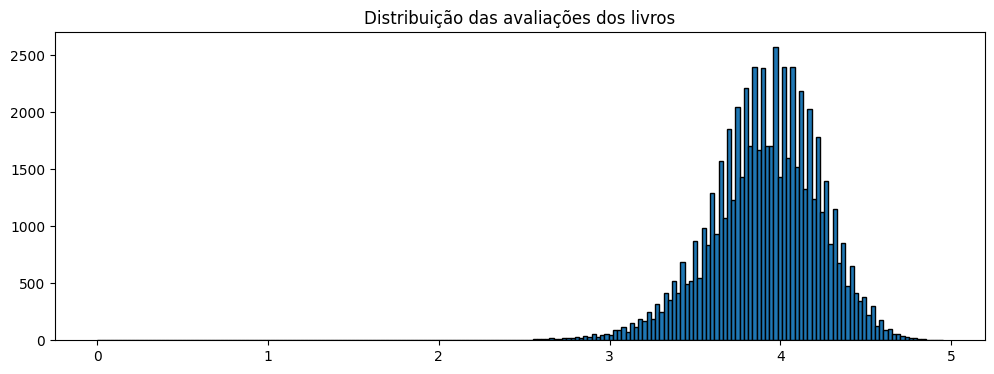

In [9]:
plt.figure(figsize=(12, 4))

plt.hist(df_train['book_rating'], bins=200, edgecolor='black', align='mid')
plt.title('Distribuição das avaliações dos livros')

plt.xticks([0, 1, 2, 3, 4, 5], rotation=0, ha='center')

plt.show()

Analisando a distribuição percebe-se que a grande maioria das avaliações médias dos livros se encontram acima de 3.5, portanto vamos discretizar essa variável nas seguintes classes:
- 0 => [0, 3.5)
- 1 => [3.5, 4)
- 2 => [4, 5]

In [10]:
bins = [0, 3.5, 4, 5.1]
labels = [0, 1, 2]

df_train['rating'] = pd.cut(df_train['book_rating'], bins=bins, labels=labels, right=False)
df_val['rating'] = pd.cut(df_val['book_rating'], bins=bins, labels=labels, right=False)
df_test['rating'] = pd.cut(df_test['book_rating'], bins=bins, labels=labels, right=False)

df_train.drop(['book_rating'], axis=1, inplace=True)
df_val.drop(['book_rating'], axis=1, inplace=True)
df_test.drop(['book_rating'], axis=1, inplace=True)

In [11]:
df_train.head()

,book_text_reviews_count,language_code,is_ebook,book_format,num_pages,publication_year,book_ratings_count,book_genre,author_rating,author_reviews_count,author_ratings_count,rating
0,3,other,False,Hardcover,172,1984,101,fiction,3.99,251,2952,2
1,13,other,False,Paperback,640,2014,101,fantasy,4.27,295835,5280268,2
2,51,eng,False,other,119,2000,1887,non-fiction,4.07,445,10679,2
3,44,eng,False,Mass-Market-Paperback,383,2011,344,fantasy,4.06,703,5438,2
4,61,other,True,other,295,2008,473,mystery,4.09,300,2459,2


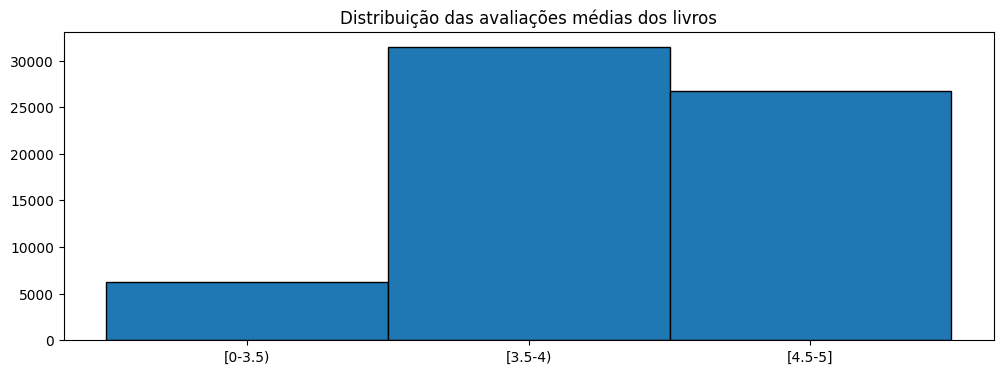

In [12]:
plt.figure(figsize=(12, 4))

_, bins, _ = plt.hist(df_train['rating'], bins=df_train['rating'].nunique(dropna=False), edgecolor='black', align='mid')
plt.title('Distribuição das avaliações médias dos livros')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
labels = ["[0-3.5)", "[3.5-4)", "[4.5-5]"]
plt.xticks(bin_centers, labels, ha='center')

plt.show()

Como já foi falado em etapas anteriores, o desbalanceamento do modelo pode gerar um viés negativo durante a aprendizagam, portanto vamos balancear a quantidade de instâncias presentes em cada classe do conjunto de treinamento por meio da técnica "random oversampling". Esse balanceamento é feito apenas no conjunto de treinamento porque o conjunto de testes visa simular uma situação de mundo real, logo os dados não estariam balanceados nessa situação.

In [13]:
def random_oversampling(num_samples : int, df : pd.DataFrame) -> pd.DataFrame:
    """
    Perform random oversampling to increase the number of samples in a DataFrame.

    Parameters:
    num_samples: The desired number of samples in the output DataFrame.
        It must be greater than or equal to the number of rows in `df`.
    df: The input DataFrame to be oversampled.

    Returns:
    A DataFrame containing the original data and the new randomly sampled rows, with a total number of rows equal to `num_samples`.
    """

    num_new_samples = num_samples - df.shape[0]

    df_samples = df.sample(n=num_new_samples, replace=True)
    df = pd.concat([df, df_samples], ignore_index=False)
    df = df.sample(frac=1, replace=False).reset_index(drop=True)
    
    return df

In [14]:
df_train_classes = [
    df_train[df_train['rating'] == 0],
    df_train[df_train['rating'] == 1],
    df_train[df_train['rating'] == 2]
]

num_samples = max(df.shape[0] for df in df_train_classes)

for i, df in enumerate(df_train_classes):
    df_train_classes[i] = random_oversampling(num_samples, df)

In [15]:
df_train = pd.concat(df_train_classes, ignore_index=True)
df_train = df_train.sample(frac=1, replace=False).reset_index(drop=True)

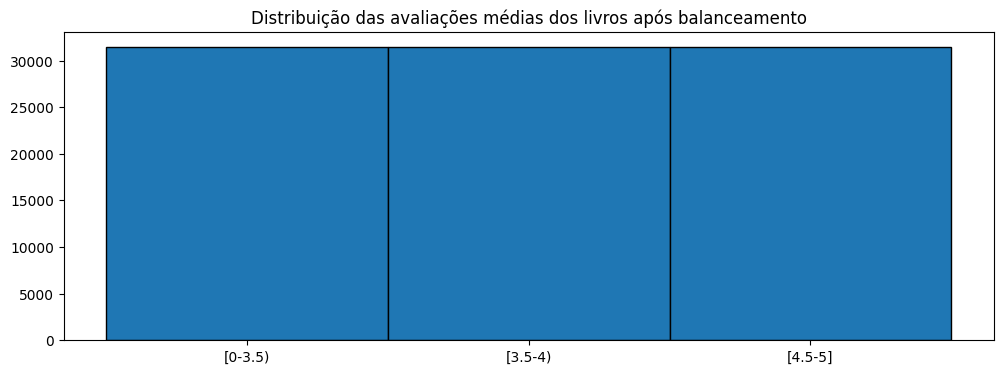

In [16]:
plt.figure(figsize=(12, 4))

_, bins, _ = plt.hist(df_train['rating'], bins=df_train['rating'].nunique(dropna=False), edgecolor='black', align='mid')
plt.title('Distribuição das avaliações médias dos livros após balanceamento')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
labels = ["[0-3.5)", "[3.5-4)", "[4.5-5]"]
plt.xticks(bin_centers, labels, ha='center')

plt.show()

### Codificação das variáveis categóricas

In [17]:
df_train['language_code'] = df_train['language_code'].apply(lambda x: 1 if x == 'eng' else 0)
df_val['language_code'] = df_val['language_code'].apply(lambda x: 1 if x == 'eng' else 0)
df_test['language_code'] = df_test['language_code'].apply(lambda x: 1 if x == 'eng' else 0)

In [18]:
# One hot encoding
df_train = pd.get_dummies(df_train, columns=['book_format'])
df_val = pd.get_dummies(df_val, columns=['book_format'])
df_test = pd.get_dummies(df_test, columns=['book_format'])

In [19]:
# One hot encoding
df_train = pd.get_dummies(df_train, columns=['book_genre'])
df_val = pd.get_dummies(df_val, columns=['book_genre'])
df_test = pd.get_dummies(df_test, columns=['book_genre'])

In [20]:
bool_cols = df_train.select_dtypes(include='bool').columns
df_train[bool_cols] = df_train[bool_cols].astype('int64')
df_val[bool_cols] = df_val[bool_cols].astype('int64')
df_test[bool_cols] = df_test[bool_cols].astype('int64')

In [21]:
df_train.dtypes

book_text_reviews_count                 int64
language_code                           int64
is_ebook                                int64
num_pages                               int64
publication_year                        int64
book_ratings_count                      int64
author_rating                         float64
author_reviews_count                    int64
author_ratings_count                    int64
rating                               category
book_format_Hardcover                   int64
book_format_Kindle-Edition              int64
book_format_Mass-Market-Paperback       int64
book_format_Paperback                   int64
book_format_ebook                       int64
book_format_other                       int64
book_genre_fantasy                      int64
book_genre_fiction                      int64
book_genre_history                      int64
book_genre_mystery                      int64
book_genre_non-fiction                  int64
book_genre_other                  

### Normalização dos dados

A normalização dos dados deve ser feita com base apenas nos dados do conjunto de treinamento, e ser aplicada a todos os conjuntos. Isso é importante para evitar vazamento de dados entre os conjuntos, visto que a utilização de dados dos conjuntos de validação e de teste para calcular os parâmetros de normalização introduz um viés nos resultados do modelo.

In [22]:
columns_to_normalize = [
    'book_text_reviews_count',
    'num_pages',
    'publication_year',
    'book_ratings_count',
    'author_rating',
    'author_reviews_count',
    'author_ratings_count'
]

In [23]:
scaler = MinMaxScaler()

In [24]:
scaler.fit(df_train[columns_to_normalize])

MinMaxScaler()

In [25]:
df_train[columns_to_normalize] = scaler.transform(df_train[columns_to_normalize])
df_val[columns_to_normalize] = scaler.transform(df_val[columns_to_normalize])
df_test[columns_to_normalize] = scaler.transform(df_test[columns_to_normalize])

### Analisando a Matriz de Correlação das Features

In [26]:
# Reordenando para colocar a variável alvo no final
cols = [col for col in df_train.columns if col != 'rating'] + ['rating']
df_train = df_train[cols]
df_val = df_val[cols]
df_test = df_test[cols]

Primeiramente vamos analisar a matriz de correlação das features, para identificar se há features pouco correlacionadas com a feature alvo e se há features altamente correlacionadas entre si.  

In [27]:
correlation_matrix = df_train.corr()

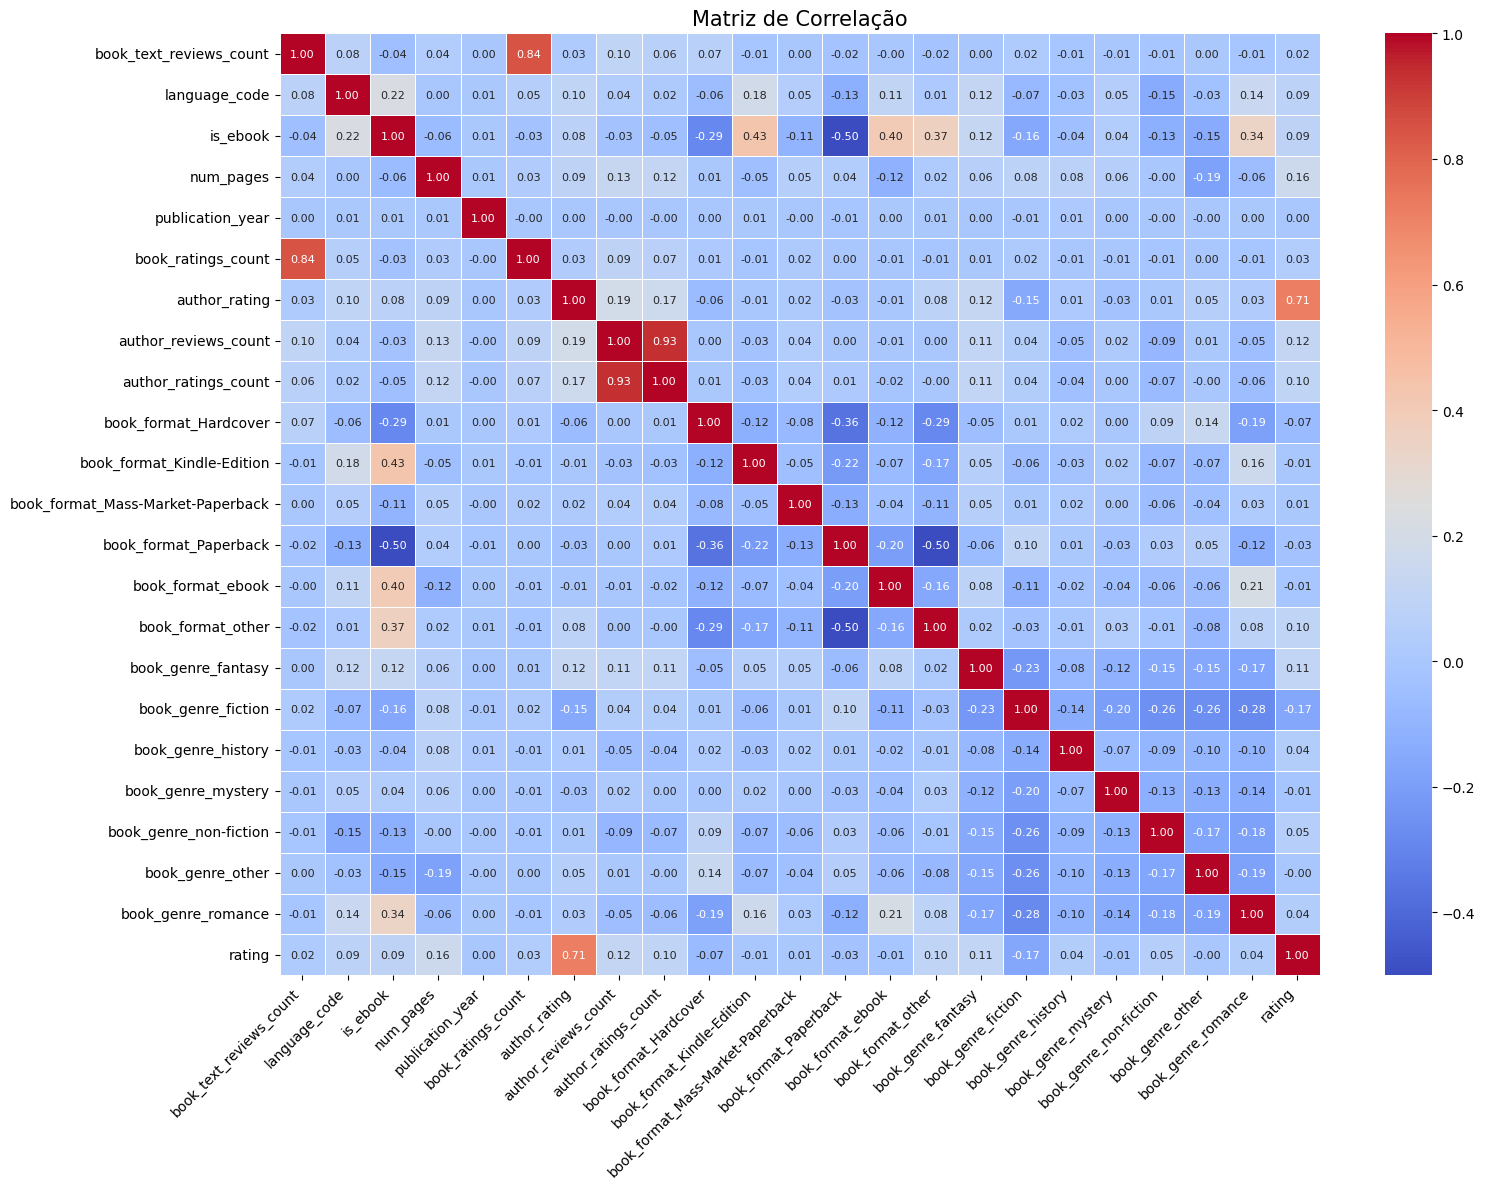

In [28]:
# Plotar a matriz de correlação com ajustes
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(correlation_matrix, 
                      annot=True, 
                      cmap='coolwarm', 
                      linewidths=0.5, 
                      fmt=".2f",
                      annot_kws={"size": 8})

# Ajustar os rótulos dos eixos
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

# Título do gráfico
plt.title('Matriz de Correlação', fontsize=15)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

Analisando essa matriz de correlação percebe-se que a variável alvo não possui correlação linear considerável com nenhuma outra feature. No entanto percebe-se que as features 'author_rating_count' e 'author_reviews_count', e as features 'book_ratings_count' e 'book_text_reviews_count' são muito correlacionadas linearmente entre si, portanto podem ser redundantes para o modelo.

In [29]:
df_train.drop(['book_text_reviews_count', 'book_ratings_count'], axis=1, inplace=True)
df_val.drop(['book_text_reviews_count', 'book_ratings_count'], axis=1, inplace=True)
df_test.drop(['book_text_reviews_count', 'book_ratings_count'], axis=1, inplace=True)

In [30]:
correlation_matrix = df_train.corr()

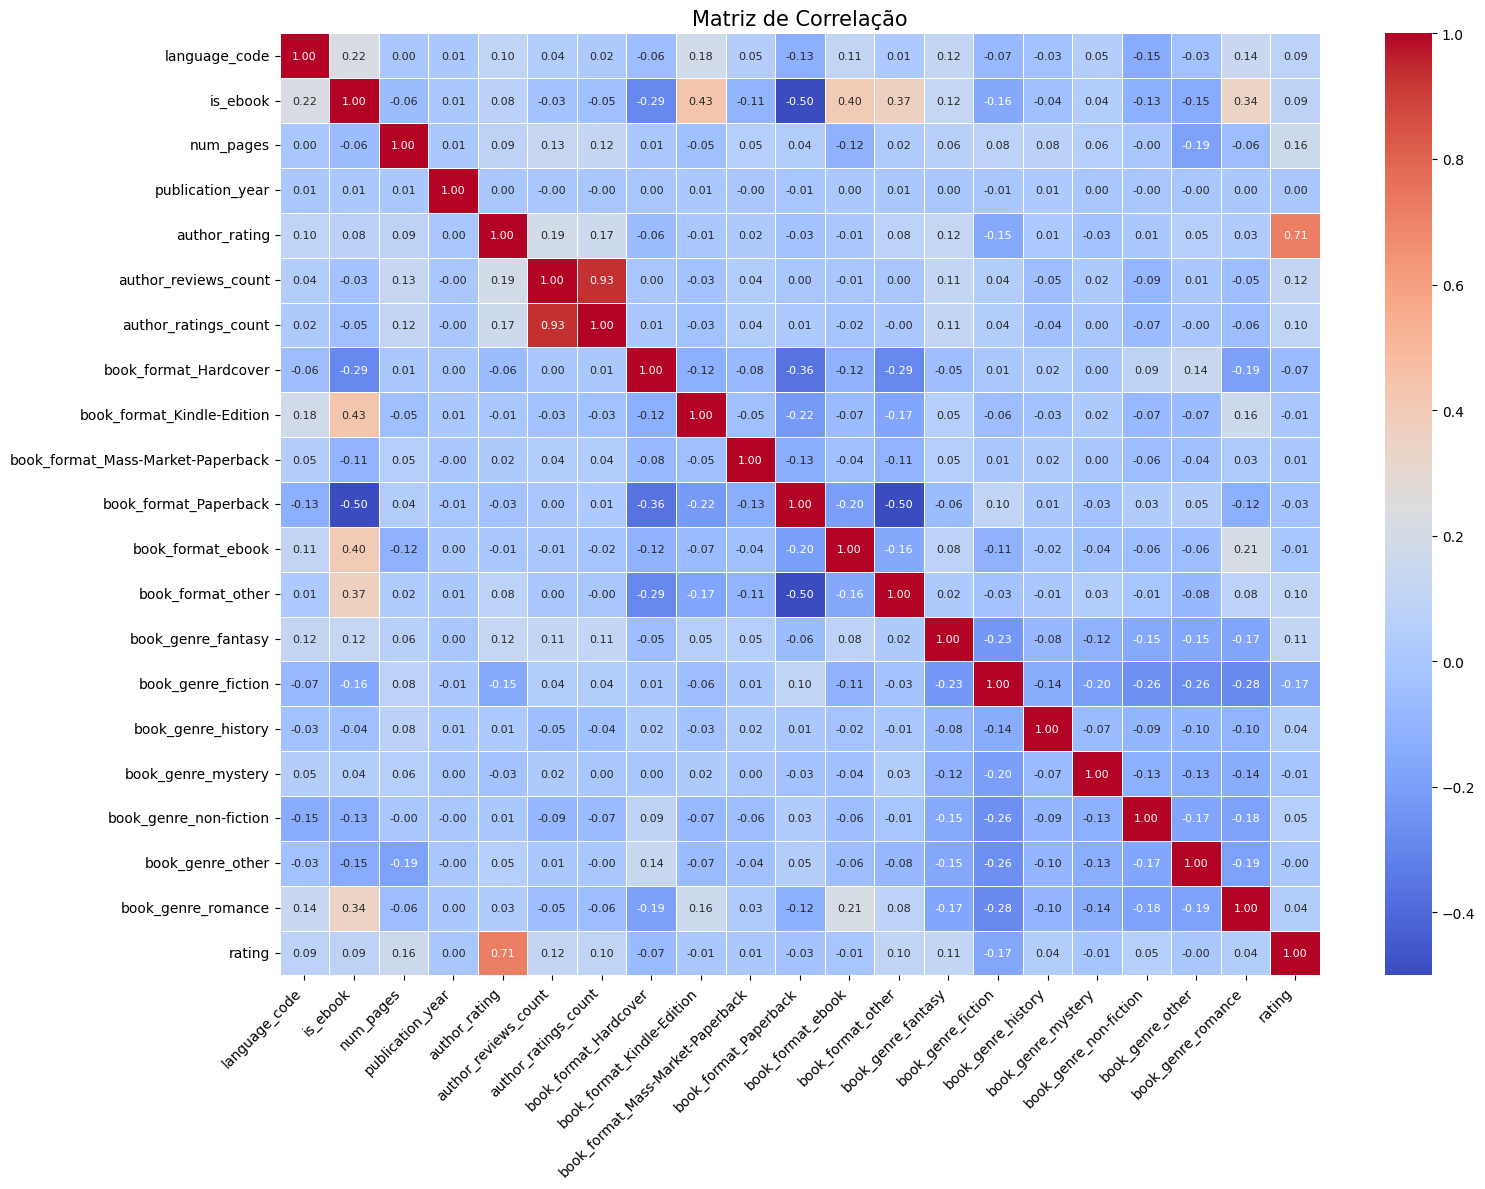

In [31]:
# Plotar a matriz de correlação com ajustes
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(correlation_matrix, 
                      annot=True, 
                      cmap='coolwarm', 
                      linewidths=0.5, 
                      fmt=".2f",
                      annot_kws={"size": 8})

# Ajustar os rótulos dos eixos
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

# Título do gráfico
plt.title('Matriz de Correlação', fontsize=15)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [32]:
df_train.drop(['publication_year'], axis=1, inplace=True)
df_val.drop(['publication_year'], axis=1, inplace=True)
df_test.drop(['publication_year'], axis=1, inplace=True)

In [33]:
correlation_matrix = df_train.corr()

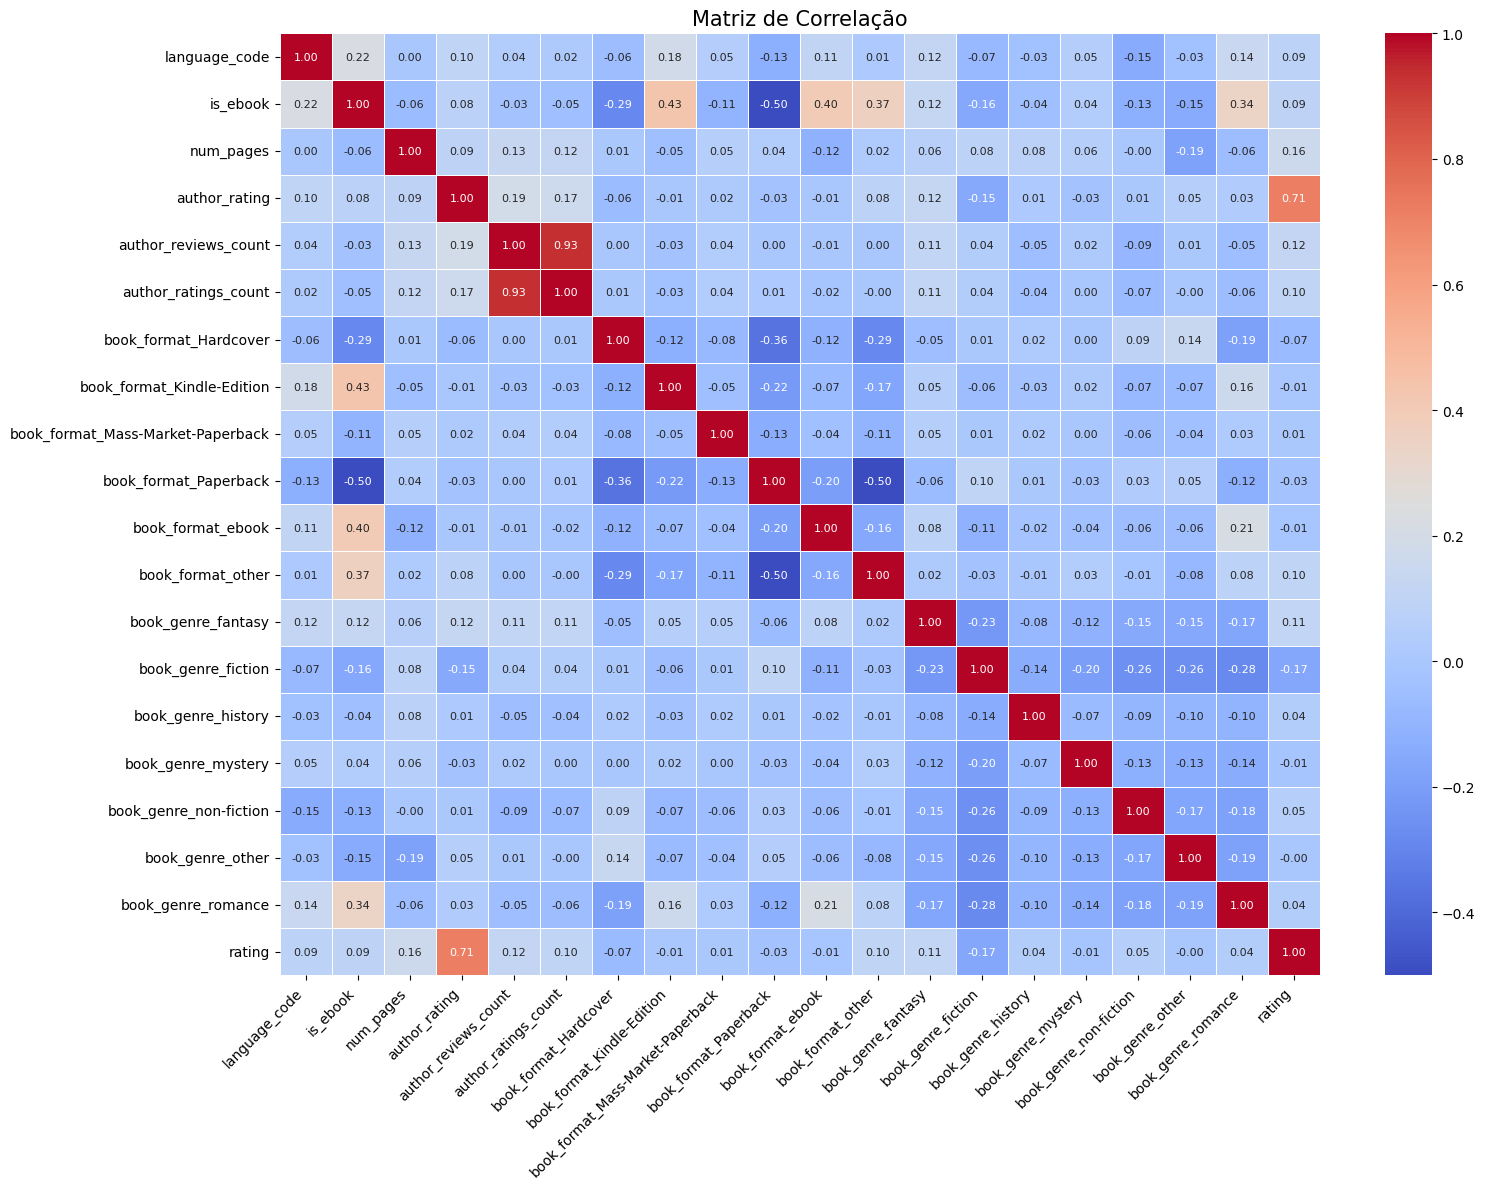

In [34]:
# Plotar a matriz de correlação com ajustes
plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(correlation_matrix, 
                      annot=True, 
                      cmap='coolwarm', 
                      linewidths=0.5, 
                      fmt=".2f",
                      annot_kws={"size": 8})

# Ajustar os rótulos dos eixos
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=10)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=10)

# Título do gráfico
plt.title('Matriz de Correlação', fontsize=15)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

### Salvando o dataset

In [ ]:
df_train.to_csv('../data/treated_data/train.csv', index=False, sep=';', encoding='utf-8', header=True)
df_val.to_csv('../data/treated_data/val.csv', index=False, sep=';', encoding='utf-8', header=True)
df_test.to_csv('../data/treated_data/test.csv', index=False, sep=';', encoding='utf-8', header=True)